# House price prediction

We use the classic [house price dataset from kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction) to fit a simple linear regression model to predict house price.

This notebook has code for ridge regression, stochastic gradient descent and cross validation coded from scratch.

In [1]:
# import dependancies
import numpy as np
import pandas as pd
import scipy
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings

import matplotlib.pylab as plt
import seaborn as sns;
sns.set_context('poster')
sns.set_style('darkgrid')

In [2]:
warnings.simplefilter("ignore")

# Read in data and drop nans
df = pd.read_csv('kc_house_data.csv')
df.dropna(axis=0, how='any', inplace=True)
# Drop date and zipcode as we will not use them in the analysis
df.drop(labels=['date','zipcode'],axis=1, inplace=True)
# Create development dataset "df" and test dataset "df_test" 
df, df_test = train_test_split(df, test_size=0.1)
df.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

# Create a matrix from the columns of the development dataset
# and scale these columns 
# Apply the same scaling to the test set
cols = [i for i in list(df.columns) if i not in ['id','price']]
x_dev = df.as_matrix(columns=cols)
x_test = df_test.as_matrix(columns=cols)
# Fit scaler only on dev set only
scaler = StandardScaler().fit(x_dev)
df.drop(labels=cols,axis=1,inplace=True)
df_test.drop(labels=cols,axis=1,inplace=True)
for col in cols:
    df[col] = scaler.fit_transform(x_dev[:,cols.index(col)].reshape(-1,1))
    df_test[col] = scaler.fit_transform(x_test[:,cols.index(col)].reshape(-1,1))
    

df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,8123450300,508000.0,-0.394556,-0.474029,-0.301298,-0.159894,-0.91559,-0.08606,-0.306487,-0.630002,0.296652,-0.417926,0.152727,0.242085,-0.21125,0.737289,0.518495,0.329042,-0.159781
1,5706600170,204900.0,-0.394556,-0.148579,-0.748815,-0.165154,-0.91559,-0.08606,-0.306487,-2.161199,-0.555036,-0.478696,-0.657922,0.446308,-0.21125,-2.123725,-0.282830,-1.061022,-0.166975
2,1049010300,435000.0,0.677303,-0.148579,-0.465024,-0.249981,-0.91559,-0.08606,-0.306487,-0.630002,-0.555036,-0.794696,0.513016,0.037862,-0.21125,1.269840,0.241931,-0.490364,-0.282269
3,3885804225,1010000.0,-1.466415,-0.148579,-0.672410,-0.145595,-0.91559,-0.08606,2.295643,2.432392,-1.406724,-0.393619,-0.657922,-2.412813,-0.21125,0.906606,0.043373,0.832391,-0.182455
4,3715500110,427000.0,-0.394556,-0.474029,-0.432278,-0.156307,-0.91559,-0.08606,-0.306487,0.901195,-0.555036,-0.600234,0.220281,-0.064249,-0.21125,1.188076,0.291571,-0.504997,-0.145731


In [3]:
df.shape

(19451, 19)

corr between price and bedrooms : 0.306556328477


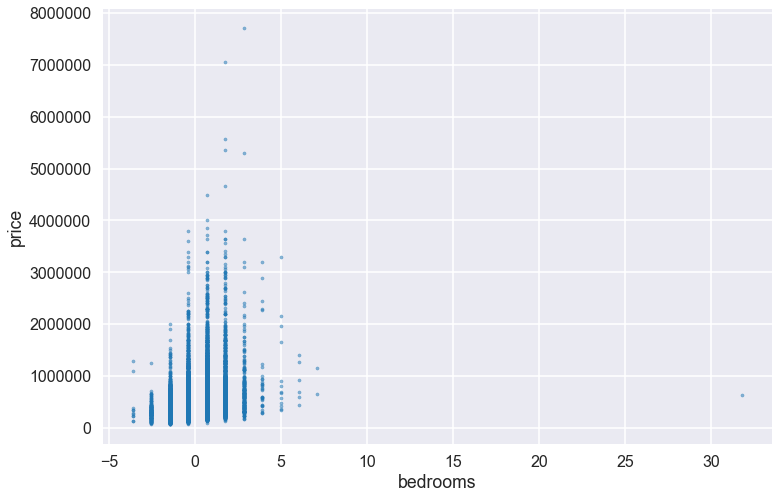

corr between price and bathrooms : 0.52227478025


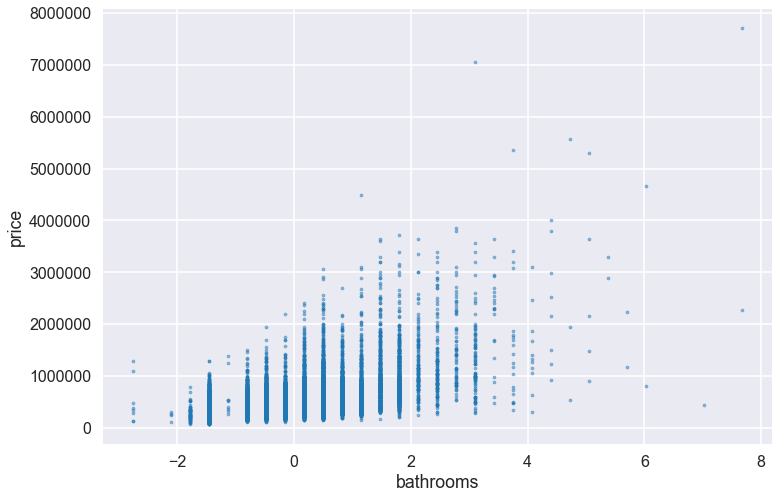

corr between price and sqft_living : 0.700339418566


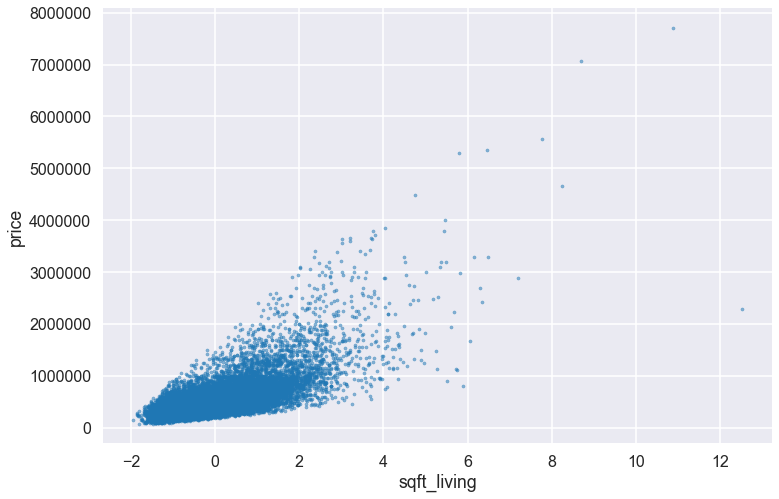

corr between price and sqft_lot : 0.0844317775107


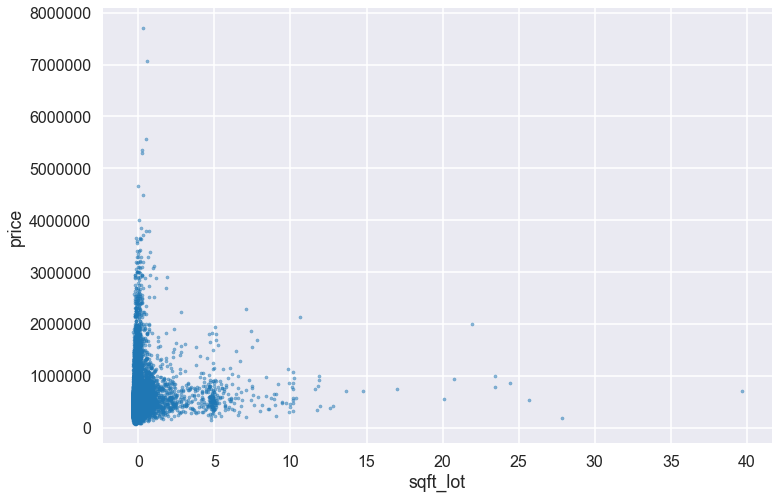

corr between price and floors : 0.253148185409


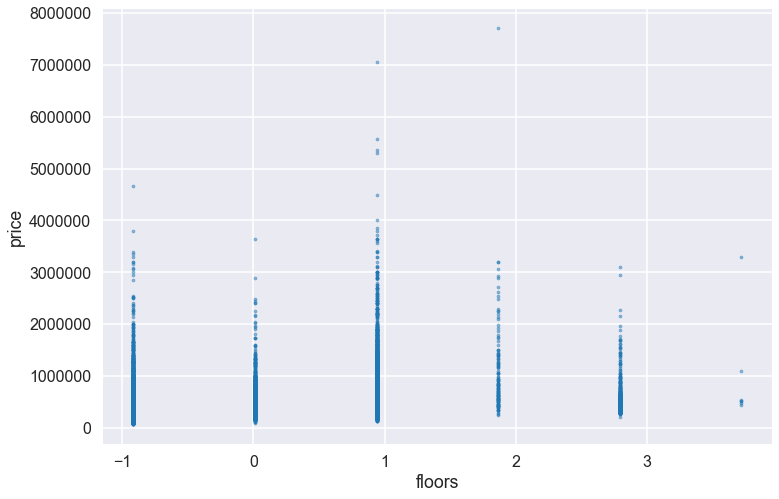

corr between price and waterfront : 0.267656314709


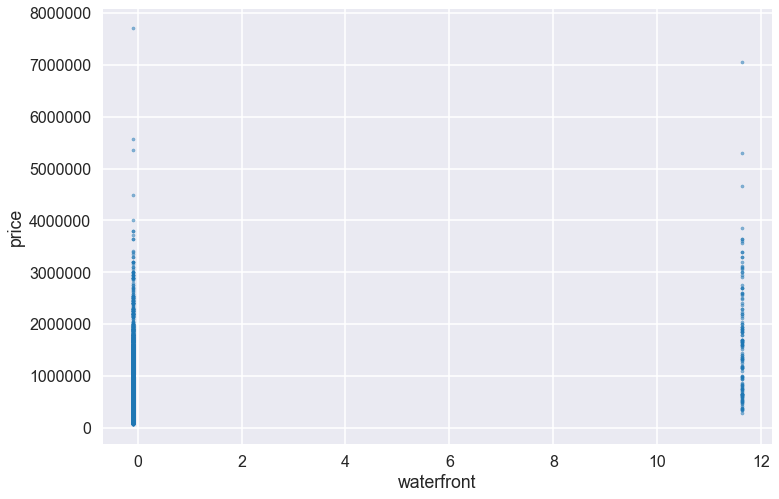

corr between price and view : 0.400391844961


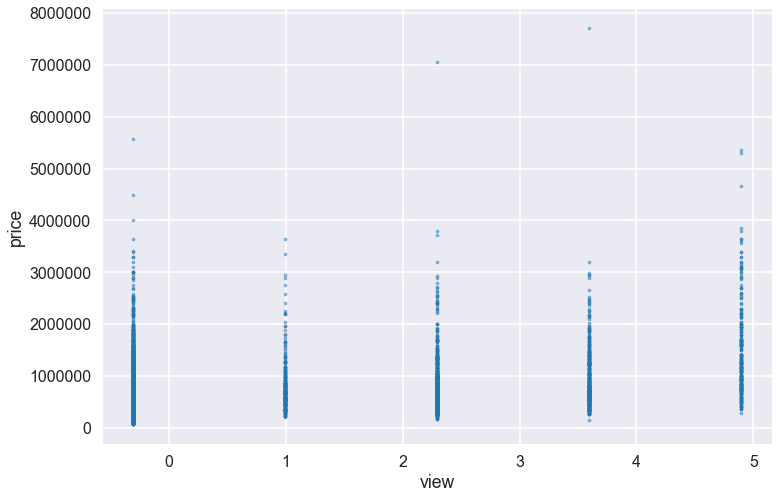

corr between price and condition : 0.0439076293957


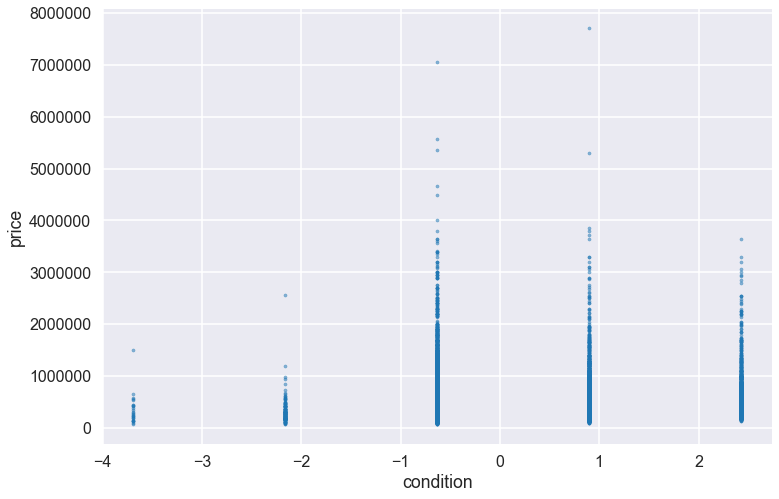

corr between price and grade : 0.666767580259


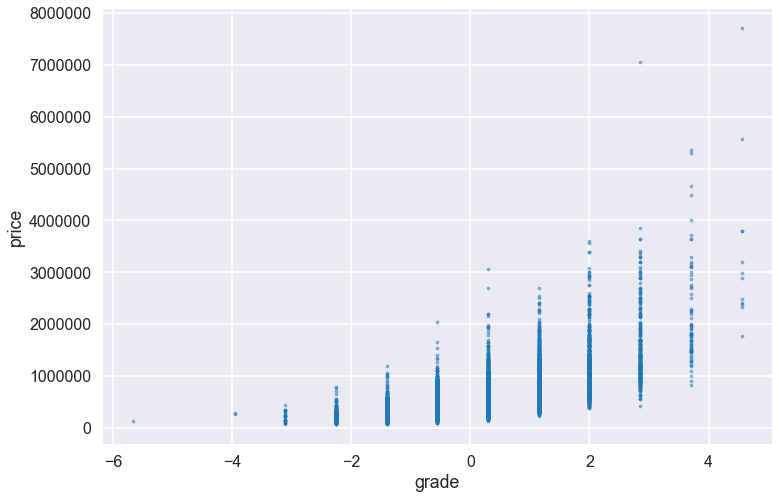

corr between price and sqft_above : 0.600743036768


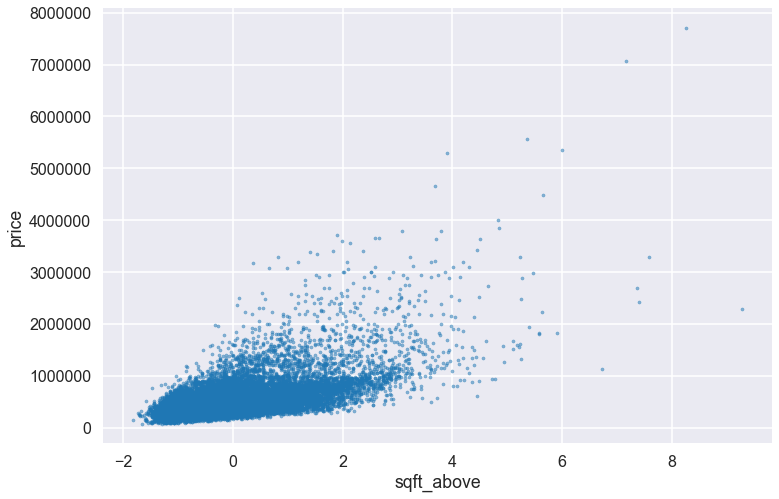

corr between price and sqft_basement : 0.331791981557


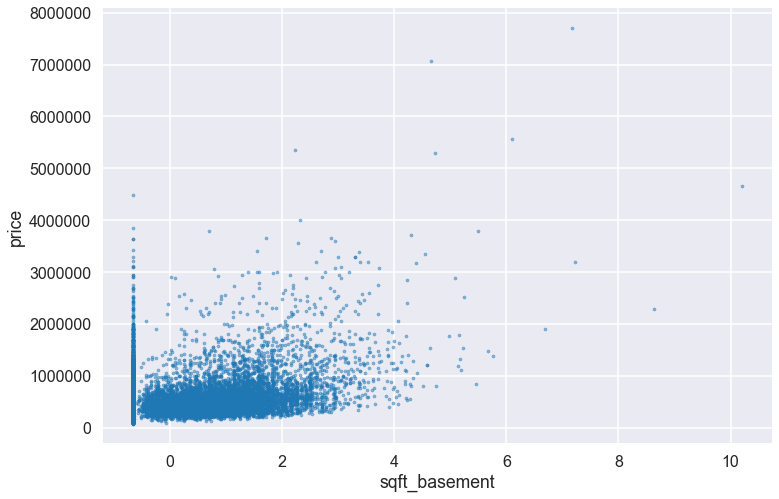

corr between price and yr_built : 0.0456892434407


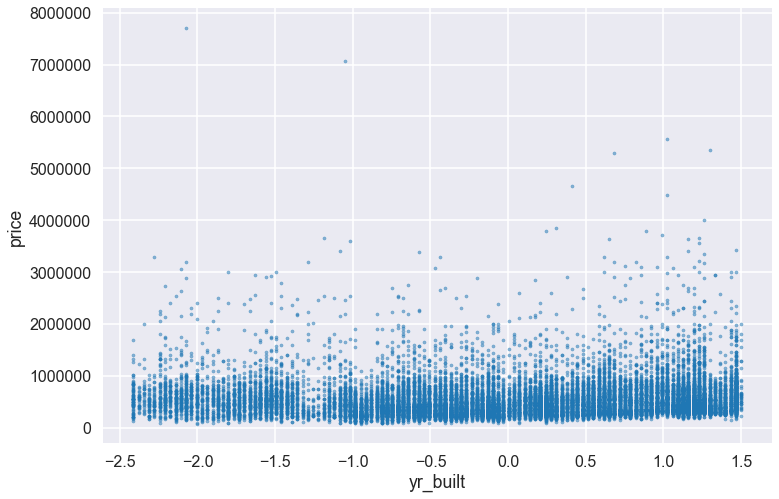

corr between price and yr_renovated : 0.128582884169


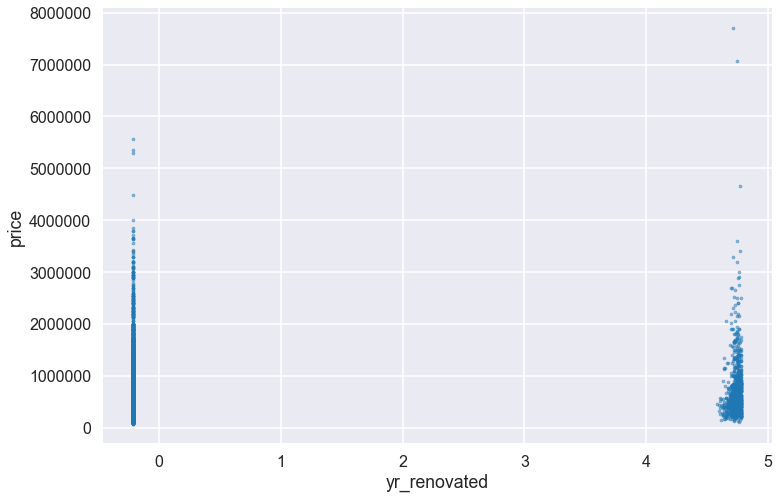

corr between price and lat : 0.307540585094


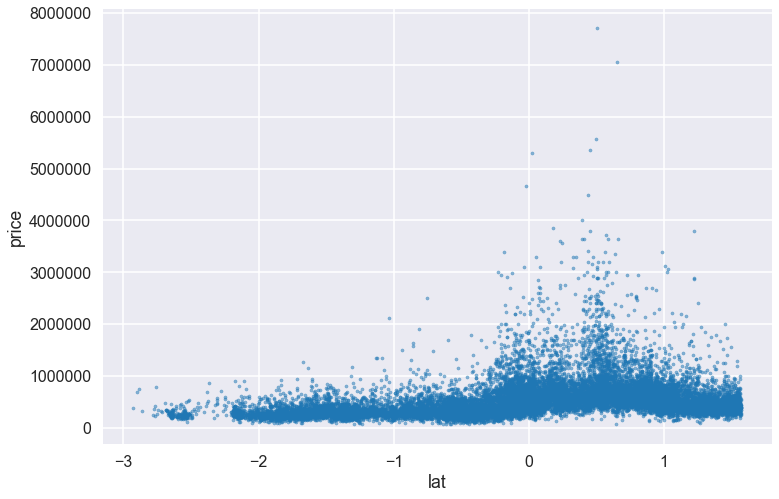

corr between price and long : 0.0171689764111


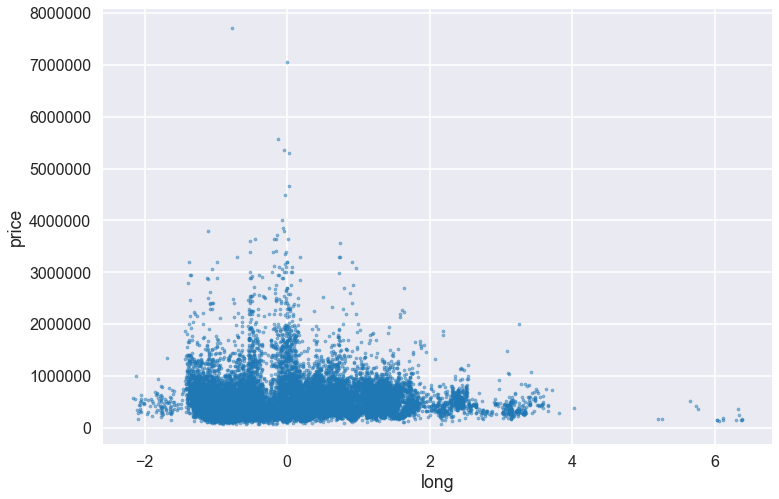

corr between price and sqft_living15 : 0.58744569827


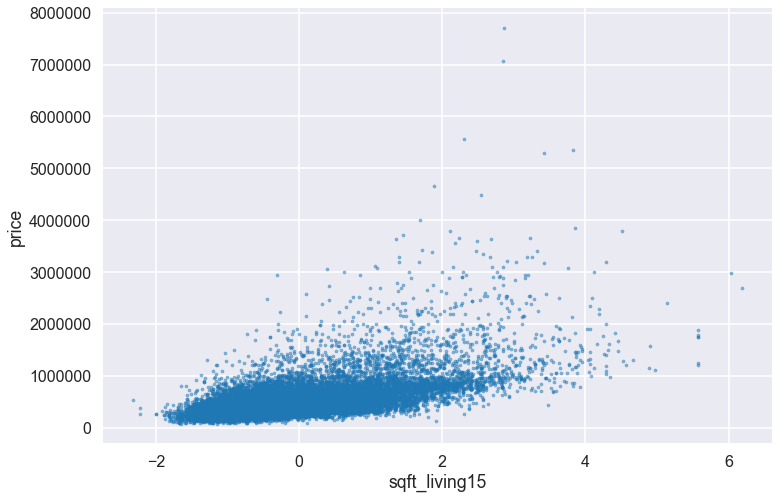

corr between price and sqft_lot15 : 0.0797301335815


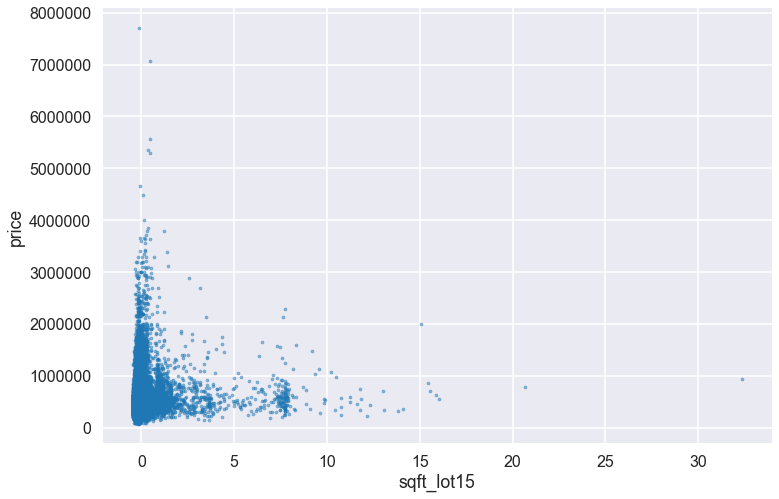

In [4]:
for col in cols:
    fig, ax = plt.subplots(figsize=(12,8))
    df.plot(kind='scatter', x=col, y='price', ax=ax, s=10, alpha=0.5)
    print("corr between price and", col,":",pearsonr(df[col].values, df.price.values)[0])
    plt.show()

# Check for covariance between features

We don't want correlated features in our model, as this makes the features redundant and could reduce the performance of the model.

In [5]:
x_check_cov = df.as_matrix(columns=cols)
x_check_cov.shape

(19451, 17)

In [6]:
Sigma = (1/x_check_cov.shape[0])*np.dot(x_check_cov.T,x_check_cov)
Sigma = abs(Sigma)
np.tri

<function numpy.lib.twodim_base.tri>

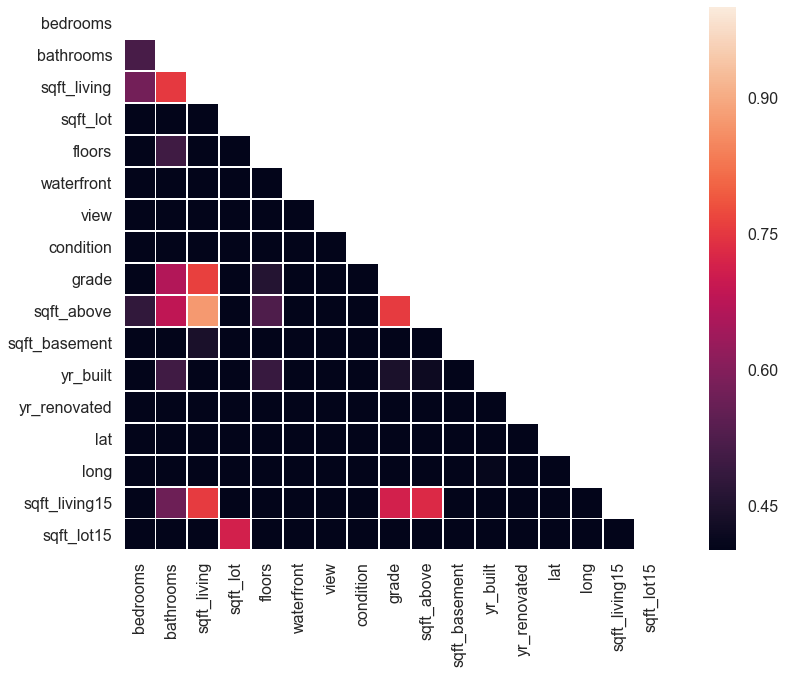

In [7]:
mask = np.zeros_like(Sigma)
mask[np.triu_indices_from(Sigma)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(Sigma, mask=mask, square=True, vmin=0.4, ax=ax, linewidths=1, xticklabels=cols, yticklabels=cols)
    plt.show()

### Some features are correlated

We see features such as sqft_above and sqft_lving are highly correlated (almost 0.8). We will get rid of redundant features.

In [8]:
discard_cols = ['grade','bathrooms','sqft_above','sqft_lot','sqft_lot15']
cols = [i for i in list(df.columns) if i not in discard_cols]
df.drop(labels=discard_cols,axis=1,inplace=True)
df_test.drop(labels=discard_cols,axis=1,inplace=True)
df.head()

,id,price,bedrooms,sqft_living,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15
0,8123450300,508000.0,-0.394556,-0.301298,-0.91559,-0.08606,-0.306487,-0.630002,0.152727,0.242085,-0.21125,0.737289,0.518495,0.329042
1,5706600170,204900.0,-0.394556,-0.748815,-0.91559,-0.08606,-0.306487,-2.161199,-0.657922,0.446308,-0.21125,-2.123725,-0.282830,-1.061022
2,1049010300,435000.0,0.677303,-0.465024,-0.91559,-0.08606,-0.306487,-0.630002,0.513016,0.037862,-0.21125,1.269840,0.241931,-0.490364
3,3885804225,1010000.0,-1.466415,-0.672410,-0.91559,-0.08606,2.295643,2.432392,-0.657922,-2.412813,-0.21125,0.906606,0.043373,0.832391
4,3715500110,427000.0,-0.394556,-0.432278,-0.91559,-0.08606,-0.306487,0.901195,0.220281,-0.064249,-0.21125,1.188076,0.291571,-0.504997


# Regularized Ridge Regression


We'll be implmenting L2 regularized regression form scratch, using mini-batch (stochastic) gradient descent. The cost function of the model is given by

$$J(W) = \frac{1}{2m}\sum_{i=1}^m (XW - y)^2 + \frac{\lambda}{2m}\sum_{i=1}^nW^2$$

where $X$, $W$, $y$, $\lambda$ and $m$ are the data, model weights, targets, regression penalty and number of data points respectively.

To tune the hyperparameters, we will implement cross validation on a validation set.

Finally, at the end we will train a model on a simpler dataset, only including the sqft_area feature and comparing the SSE of the simpler model to the SSE of the more complex model with more features.

In [9]:
class RidgeGD:
    """
    Performs ridge regression on a dataset with L2 regularization (from scratch implementation)
    """
    
    def __init__(self,lambda_=1,alpha=0.01, batchSize=32,n_iter=100,output_every=10):
        self.lambda_        = lambda_ # the penalty / regularization size
        self.alpha          = alpha # the learning rate
        self.batchSize      = batchSize # the size mini batch for gradient descent
        self.n_iter         = n_iter # the numner of iterations in mini batch gradient descent
        self.output_every   = output_every # how often to print error
        
    def cost(self,x,y,w):
        """
        Calculate the cost with current weights
        INPUT: data x, targets y, weights w
        OUTPUT: cost
        """
        # X ~ mxn
        # y ~ mx1
        # W ~ nx1
        m = x.shape[0]
        h = np.dot(x,w) # mxn * nx1 = mx1
        error = h - y
        w[0] = 0 # dont regularize bias
        J = (1/(2*m))*np.sum(error**2) + (self.lambda_/(2*m))*np.sum(w**2)
        return J
     
    def grad(self,x,w,y):
        """
        Calculate the gradient of the cost function
        INPUT: data x, targets y, weights w
        OUTPUT: gradient of cost function
        """
        m = x.shape[0]
        h = np.dot(x,w)
        error = h - y # mx1
        w[0] = 0 # dont regularize bias term
        partial = (1/m)*np.dot(x.T,error) + (self.lambda_/m)*w # nx1
        return partial
    
    def update_weights(self,x,w,y):
        """
        Update the model weights
        INPUT: data x, targets y, current weights w
        OUTPUT: updated weights
        """
        partial = self.grad(x,w,y)
        w = w - self.alpha*partial
        return w
    
    def get_mini_batch(self,x,y,i):
        """
        Get a minibatch of the data
        INPUT: data x, targets y, iteration i
        OUTPUT: subset of the data X,y
        """
        x_mini = x[i*self.batchSize:(i+1)*self.batchSize,:]
        y_mini = y[i*self.batchSize:(i+1)*self.batchSize,:]
        return x_mini,y_mini
    
    def add_bias(self,x):
        """
        Add a column of 1's as the first column in the data x
        INPUT: data x
        OUTPUT: data x with a column of 1's as first column
        """
        x_bias = np.ones((x.shape[0],1))
        x = np.concatenate((x_bias,x),axis=1)
        return x
    
    def init_weights(self,x):
        """
        Initialize the model weights at random
        INPUT: data x
        OUTPUT: random weights
        """
        return (np.random.random((x.shape[1],1))*2 - 1)*1e-2
    
    def fit(self,x,y):
        """
        Fit a model to the data using mini batch gradient descent
        INPUT: data x, targets y
        OUTPUT: model weights w
        """
        if np.all(x[:,0] == np.ones(x.shape[0])):
            pass
        else:
            x = self.add_bias(x)
            
        w = self.init_weights(x)
        n = np.arange(len(x))
        
        """
        Perform mini batch gradient descent
        """
        J = []
        for epoch in range(1, self.n_iter + 1):
            for i in range(0,round(x.shape[0]/self.batchSize)):
                X_mini,Y_mini = self.get_mini_batch(x=x,y=y,i=i)
                J.append(self.cost(x=X_mini,y=Y_mini,w=w))
                w = self.update_weights(x=x,w=w,y=y)

        return w
    
    def predict(self,x,w):
        """
        Predict the target of new input data
        INPUT: data x, learned weights w
        OUTPUT: predicted targets
        """
        x_bias = np.ones((x.shape[0],1))
        x = np.concatenate((x_bias,x),axis=1)
        return np.dot(x,w)

# SSE

Sum of squared error (SSE), is defined as follows

$$\text{SSE} = \sum_{i=1}^{m}(y_i - \hat{y_i})^2$$

where $y_i$ is the true target value, and $\hat{y_i}$ is the predicted target value.

We will use SSE as a metric for the error of a model, and compare SSE values to determine the bets model hyperparameters and best ultimate model.

In [10]:
# The features we will be using to predict price
[col for col in list(df.columns) if col not in ['id','price']]

['bedrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'condition',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15']

In [11]:
# Create matrices X and Y for training and testing
X = df.as_matrix(columns=[col for col in list(df.columns) if col not in ['id','price']])
Y = df.as_matrix(columns=['price'])
X_test = df_test.as_matrix(columns=[col for col in df_test if col not in ['id','price']])
Y_test = df_test.as_matrix(columns=['price'])

## Cross Validate

We use cross validation to find the best training rate $\alpha$ and penalty $\lambda$

In [12]:
def CrossValidate(x,y,alpha,lambda_):
    """
    Use cross validation on the development data set to obtain the optimal hyperparameters
    INPUT: data x, targets y, alpha (start, end, num), lambda (start, end, num)
    OUTPUT: errs_dict, a dictionary of (alpha,lambda) keys and SSE error values
    """
    
    alphas = np.linspace(alpha[0],alpha[1],alpha[2])
    lambdas_ = np.logspace(lambda_[0],lambda_[1],lambda_[2]).astype(int)
    
    # Use k-fold (10-fold) cross val
    k=10
    cv = KFold(n_splits=k, shuffle=False)
    train_indices = [i[0] for i in cv.split(x)]
    val_indices = [i[1] for i in cv.split(x)]
    
    errs_dict = {(a,l):0 for a,l in zip(alphas,lambdas_)}

    # Loop over alphas and lambdas hyperparams
    for a in alphas:
        print("alpha:",a)
        for lam in lambdas_:
            cv_sse_err = []
            for i in range(k):
                
                x_train = x[train_indices[i],:]
                y_train = y[train_indices[i],:]
                
                x_val = x[val_indices[i],:]
                y_val = y[val_indices[i],:]
                
                model = RidgeGD(lambda_=lam, alpha=a, batchSize=64, n_iter=50, output_every=50)
                W = model.fit(x=x_train,y=y_train)
                
                sse = sum((model.predict(x_val,W) - y_val)**2)[0]
                cv_sse_err.append(sse)
                
            errs_dict[(a,lam)] = (1/k)*sum(cv_sse_err)
    
    return errs_dict

In [13]:
# This takes about 10 minutes to run
errs_dict = CrossValidate(X,Y,(0.5,0.69,5),(1,2,5))

alpha: 0.5
alpha: 0.5475
alpha: 0.595
alpha: 0.6425
alpha: 0.69


In [14]:
# Use the minimum value to train the final model
min(errs_dict, key=errs_dict.get)

(0.64249999999999996, 31.622776601683793)

In [86]:
# Train model with optimim hyperparams above
model = RidgeGD(lambda_=32,alpha=0.64, batchSize=32, n_iter=200, output_every=50)
# Model weights
W = model.fit(x=X,y=Y)

## R-squared & RSS

The R-squared value is a metric used to evaluate a linear regression model. Similarly for RSS (residual sum of squares)

$$R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}}$$

where $SS_{\text{res}} = \sum_i ( y_i - f_i)^2$ and $SS_{\text{tot}} = \sum_i ( y_i - \bar{y_i})^2$.

Here, $f_i$ is the model's prediction of the $i$'th observation and $y_i$ is the true target value of the $i$'th observation.

An $R^2$ value of 1 indicates a perfect model. A value of $x<1$ indicates that $x\%$ of the variance of the data is explained by the model.


### The RSS is given by

$$RSS = \sum_i (y_i - f_i)^2$$

again $f_i$ is the model's prediction of the $i$'th observation and $y_i$ is the true target value of the $i$'th observation.

We can see that RSS and $SS_{\text{res}}$ are equivalent.

In [87]:
class Metrics:
    """
    Metrics we will use in evaluating our models
    """
    
    def r_squared(self, model, x, y, w=None, scikit_flag=False):
        """
        Calculate the R^2 value of an input model
        INPUT: model, X (data), y (targets), W (weights, if applicable), scikit_flag (if using scikit)
        """
        if not scikit_flag:
            f = model.predict(x=x, w=w)
            sstot = ((y - np.mean(y))**2).sum()
            ssres = ((y - f)**2).sum()
            return 1 - (ssres/sstot)
        else:
            return model.score(X=x, y=y)
    
    def rss(self, model, x, y, w=None, scikit_flag=False):
        if not scikit_flag:
            f = model.predict(w=w, x=x)
            return ((y - f)**2).sum()
        else:
            f = model.predict(X=x)
            return ((y - f)**2).sum()

### Comparison to package - Scikit

We compare our from scratch implemtnation to that of scikit's ridge regression model.

In [88]:
# train the scikit model
clf = Ridge(alpha=32, solver='saga')
model_sk = clf.fit(X=X, y=Y)

In [89]:
mets = Metrics()
train_r2 = mets.r_squared(model, X, Y, W)
test_r2 = mets.r_squared(model, X_test, Y_test, W)
train_r2_scikit = mets.r_squared(model_sk, X, Y, scikit_flag=True)
test_r2_scikit = mets.r_squared(model_sk, X_test, Y_test, scikit_flag=True)

train_rss = mets.rss(model, X, Y, W)
test_rss = mets.rss(model, X_test, Y_test, W)
train_rss_scikit = mets.rss(model_sk, X, Y, scikit_flag=True)
test_rss_scikit = mets.rss(model_sk, X_test, Y_test, scikit_flag=True)

In [90]:
print("Model\t\t|\tR2 Train\t|\tR2 Test\t\t|\tRSS Train\t|\tRSS Test")
print("---------------------------------------------------------------------------------------------------------------")
print("From Scratch SGD\t", train_r2, "\t", test_r2, "\t", train_rss, "\t", test_rss)
print("Scikit\t\t\t", train_r2_scikit, "\t", test_r2_scikit, "\t", train_rss_scikit, "\t", test_rss_scikit)

Model		|	R2 Train	|	R2 Test		|	RSS Train	|	RSS Test
---------------------------------------------------------------------------------------------------------------
From Scratch SGD	 0.379873696933 	 0.380165640186 	 1.6000229948e+15 	 2.06168054821e+14
Scikit			 0.663962526283 	 0.646682789394 	 8.67029317099e+14 	 1.17519658102e+14


## Conclusions

Our from scratch SGD ridge regression model performs poorly compared to a standard open source package such as scikit; our test $R^2$ is only 0.38 while the scikit model achieved a test score of 0.65. Similarly, the RSS of the scikit model is much lower (an order of magnitude on training data and half as low on test data) using the scikit implementation.

This would indicate that our model could not find the (global) minimum, and became stuck somewhere in the feature / cost space during gradient descent. Perhaps a more sophistaced algorithm may have perforrmed better, such as momentum or Adam.

We will train a model on a simpler dataset, using only the sqft_area feature of the original dataset and calculating the SSE of the model.

# Simpler Model -  sqft_area feature only

In [19]:
# Create simple dataset
# First, cross validate the model to find optimum hyperparms
X_simple = df.as_matrix(columns=['sqft_living'])
errs_dict = CrossValidate(X_simple,Y,(0.98,1.3,5),(1,2,5))

alpha: 0.98
alpha: 1.06
alpha: 1.14
alpha: 1.22
alpha: 1.3


In [20]:
# Use these optimum hyperparams in simple model
min(errs_dict, key=errs_dict.get)

(0.97999999999999998, 10.0)

In [91]:
Y = df.as_matrix(columns=['price'])
model_simple = RidgeGD(lambda_=10, alpha=1, batchSize=32, n_iter=200, output_every=50)
W_simple = model_simple.fit(x=X_simple,y=Y)

In [92]:
# Make a test data set using only sqft_living
X_test_simple = df_test.as_matrix(columns=['sqft_living'])

In [93]:
clf = Ridge(alpha=100, solver='saga')
model_sk = clf.fit(X=X_simple, y=Y)

In [94]:
mets = Metrics()
train_r2_simple = mets.r_squared(model, X_simple, Y, W_simple)
test_r2_simple = mets.r_squared(model, X_test_simple, Y_test, W_simple)
train_r2_scikit_simple = mets.r_squared(model_sk, X_simple, Y, scikit_flag=True)
test_r2_scikit_simple = mets.r_squared(model_sk, X_test_simple, Y_test, scikit_flag=True)

train_rss_simple = mets.rss(model, X_simple, Y, W_simple)
test_rss_simple = mets.rss(model, X_test_simple, Y_test, W_simple)
train_rss_scikit_simple = mets.rss(model_sk, X_simple, Y, scikit_flag=True)
test_rss_scikit_simple = mets.rss(model_sk, X_test_simple, Y_test, scikit_flag=True)

In [95]:
print("Model\t\t|\tR2 Train\t|\tR2 Test\t\t|\tRSS Train\t|\tRSS Test")
print("---------------------------------------------------------------------------------------------------------------")
print("From Scratch SGD\t", train_r2_simple, "\t", test_r2_simple, "\t", train_rss_simple, "\t", test_rss_simple)
print("Scikit\t\t\t", train_r2_scikit_simple, "\t\t", test_r2_scikit_simple, "\t", train_rss_scikit_simple, "\t", test_rss_scikit_simple)

Model		|	R2 Train	|	R2 Test		|	RSS Train	|	RSS Test
---------------------------------------------------------------------------------------------------------------
From Scratch SGD	 0.490475171693 	 0.508528792515 	 1.31465386597e+15 	 1.63472161947e+14
Scikit			 0.490449824838 		 0.507930286357 	 1.31471926482e+15 	 1.63671235858e+14


### Plot from scratch model

SWe'll plot our from scratch model to see how well it fits the data and since we only use one feature (sqft_living), it's easier to plot on an x-y axis.

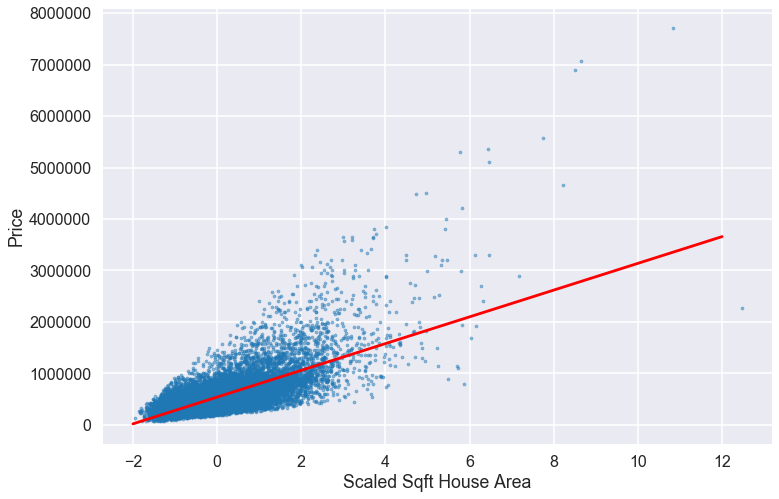

In [127]:
def line(m,b,x):
    """
    Return the points on a line
    INPUT: m (line slope), b (line intersect / bias), x (x values of the line)
    OUTPUT: an array of y values for every corresponding x value
    """
    return m*x+b

# Plot appropriate weights and biases and data to see how well line fits through data
l = line(m=W_simple[1],b=W_simple[0],x=np.linspace(-2,12,1000))
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(X_simple,Y,s=10,alpha=0.5)
ax.plot(np.linspace(-2,12,1000),l,color='r')
ax.set_ylabel("Price")
ax.set_xlabel("Scaled Sqft House Area")
plt.show()

In [125]:
print("Model\t\t\t|\tR2 Train\t|R2 Test\t|RSS Train\t|\tRSS Test")
print("---------------------------------------------------------------------------------------------------------------")
print("From Scratch SGD (complex)\t", round(train_r2,2), "\t\t", round(test_r2,2), "\t\t", round(train_rss,2), "\t", round(test_rss,2))
print("Scikit (complex)\t\t", round(train_r2_scikit,2), "\t\t", round(test_r2_scikit,2), "\t\t", round(train_rss_scikit,2), "\t", round(test_rss_scikit,2))
print("From Scratch SGD (simple)\t", round(train_r2_simple,2), "\t\t", round(test_r2_simple,2), "\t\t", round(train_rss_simple,2), "\t", round(test_rss_simple,2))
print("Scikit (simple)\t\t\t", round(train_r2_scikit_simple,2), "\t\t", round(test_r2_scikit_simple,2), "\t\t", round(train_rss_scikit_simple,2), "\t", round(test_rss_scikit_simple,2))

Model			|	R2 Train	|R2 Test	|RSS Train	|	RSS Test
---------------------------------------------------------------------------------------------------------------
From Scratch SGD (complex)	 0.38 		 0.38 		 1.6000229948e+15 	 2.06168054821e+14
Scikit (complex)		 0.66 		 0.65 		 8.67029317099e+14 	 1.17519658102e+14
From Scratch SGD (simple)	 0.49 		 0.51 		 1.31465386597e+15 	 1.63472161947e+14
Scikit (simple)			 0.49 		 0.51 		 1.31471926482e+15 	 1.63671235858e+14


# Conclusions

We can see from the table above, that using our from scratch implementation, the simpler model, using only sqft_area, performed better than the complex from scratch model using all the features. 

However, the scikit implementation performed worse in the simple model than the complex model with many features.

We can conclude 2 things.

1. Using more features yields a better performing model, and therefore there is more information to be gained by using more features.

2. Always use an optimized library (scikit, tensorflow) when possible :)